# Naive Bayes Classifier

In [1]:
import pandas as pd
import random as rd
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt

## Loading Dataset

In [2]:
input_header = {"PROC_TRACEINFO" : "id",
                "OP070_V_1_angle_value": "angle_1",
                "OP090_SnapRingPeakForce_value" : "snap_ring_peak_force",
                "OP070_V_2_angle_value" : "angle_2",
                "OP120_Rodage_I_mesure_value" : "rodage_i",
                "OP090_SnapRingFinalStroke_value" : "snap_ring_final_stroke",
                "OP110_Vissage_M8_torque_value" : "vissage_m8_torque",
                "OP100_Capuchon_insertion_mesure" : "capuchon_insertion",
                "OP120_Rodage_U_mesure_value" : "rodage_u",
                "OP070_V_1_torque_value" : "torque_1",
                "OP090_StartLinePeakForce_value" : "start_line_peak_force",
                "OP110_Vissage_M8_angle_value" : "vissage_m8_angle",
                "OP090_SnapRingMidPointForce_val" : "snap_ring_midpoint_force",
                "OP070_V_2_torque_value" : "torque_2"}
output_header = {"PROC_TRACEINFO" : "id",
                 "Binar OP130_Resultat_Global_v" : "result"}

train_input = pd.read_csv("../data/train_inputs.csv", header=0).rename(columns=input_header)
train_output = pd.read_csv("../data/train_output.csv", header=0).rename(columns=output_header)

In [3]:
train_input_ = train_input[train_input.columns[~train_input.columns.isin(["id", "capuchon_insertion"])]]
X_train, X_test, y_train, y_test = train_test_split(train_input_, train_output["result"], test_size = 0.3, random_state = 123)

## Gaussian Classifier

In [4]:
# Create model
gnb_model = GaussianNB()
gnb_model.fit(X_train, y_train)

# Prediciton
y_pred = gnb_model.predict(X_test)

# Evaluation
metrics.accuracy_score(y_test, y_pred)

0.9908256880733946

The result seems to good to be true, especially for a naive bayes classifier...  
Maybe the model is overfitting the data. As we know there are only a few defective individuals (lass then 1%). So even if the model mis-classifies them, it won't affect the score all that much...

/home/fabien/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


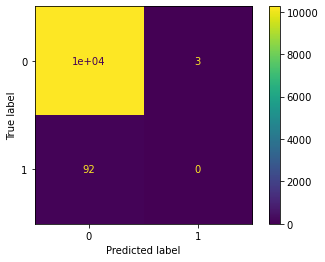

In [5]:
# Compute confusion matrix
M = confusion_matrix(y_test, y_pred)
# tn, fp, fn, tp = M.ravel() # True/False negative/positive

# Plot confusion matrix
plot_confusion_matrix(gnb_model, X_test, y_test)
plt.show()

In the confusion matrix we can clearly see that valid individuals are properly classified whereas **all** the defective individuals are classified as valid individuals. The model is definitely overfitting the data due to the misrepresentation of defective individuals in the population.

## Gaussian Classifier with Balanced Classes

### Remove Individuals

In [6]:
# Copy dataset
train_input_remove = train_input.copy()
train_output_remove = train_output.copy()

# Select index
defect_index = train_output.index[train_output["result"] == 1].tolist()
valid_index = train_output.index[train_output["result"] == 0].tolist()

# Randomly remove some valid individuals
rd.shuffle(valid_index) # Shuffle in order to eliminate "production correlation"
train_input_remove = train_input_remove.iloc[valid_index[:len(defect_index)] + defect_index,:]
train_output_remove = train_output_remove.iloc[valid_index[:len(defect_index)] + defect_index,:]

# Create new datasets
train_input_remove = train_input_remove[train_input_remove.columns[~train_input_remove.columns.isin(["id", "capuchon_insertion"])]]
X_train, X_test, y_train, y_test = train_test_split(train_input_remove, train_output_remove["result"], test_size = 0.3, random_state = 123)

# Create model
gnb_balanced_model = GaussianNB()
gnb_balanced_model.fit(X_train, y_train)

# Prediction
y_pred = gnb_balanced_model.predict(X_test)

# Evaluation
metrics.accuracy_score(y_test, y_pred)

0.6010928961748634

/home/fabien/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


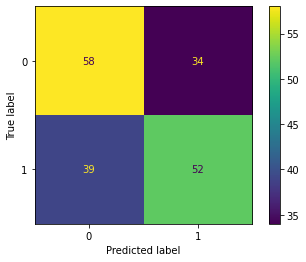

In [7]:
# Compute confusion matrix
M = confusion_matrix(y_test, y_pred)
# tn, fp, fn, tp = M.ravel() # True/False negative/positive

# Plot confusion matrix
plot_confusion_matrix(gnb_balanced_model, X_test, y_test)
plt.show()

With the classes (valid/defective) having equal proportion in the global population there is an improvement. The classifier is now able to classify some of the defective individuals as defective. On the other hand, there are now more missclassified valid individuals...

## Cross Validation

In [8]:
train_input_ = train_input[train_input.columns[~train_input.columns.isin(["id", "capuchon_insertion"])]]

gnb_cross = GaussianNB()

scores = cross_val_score(gnb_cross, train_input_, train_output["result"], cv = 5)
scores

array([0.99087353, 0.99116326, 0.9910184 , 0.9910184 , 0.99116326])